In [1]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
import networkx as nx

In [2]:
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from mpl_toolkits.mplot3d import Axes3D

In [22]:
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [4]:
#%matplotlib notebook

In [5]:
data, cluster_id = sklearn.datasets.make_blobs(n_samples = 20, n_features = 3, random_state=1, cluster_std=3)

In [6]:
umap_object = umap.UMAP(n_neighbors=5, min_dist=.25).fit(data)

In [7]:
points = umap_object.embedding_

In [9]:
# create dataframe of edges
coo_graph = umap_object.graph_.tocoo()
edge_df = pd.DataFrame(
        np.vstack([coo_graph.row, coo_graph.col, coo_graph.data]).T,
        columns=("source", "target", "weight"),
    )
edge_df["source"] = edge_df.source.astype(np.int32)
edge_df["target"] = edge_df.target.astype(np.int32)

In [13]:
edge_df[:3]

,source,target,weight
0,0,1,0.569978
1,0,9,0.397779
2,0,18,0.606066


In [10]:
# get estimate of initial spectral embedding
network_graph = nx.Graph()
network_graph.add_weighted_edges_from([(row.source, row.target, row.weight) for idx, row in edge_df.iterrows()])
spectral_embedding = list(pd.DataFrame(nx.spectral_layout(network_graph)).T.sort_index().values)

In [11]:
# create a random intitial embedding for visualization purposes
random_embedding = np.random.rand(np.shape(points)[0], np.shape(points)[1])

In [12]:
# creata dataframe of points and embeddings
point_df = pd.DataFrame()
point_df['data_'] = list(data)
point_df['embedding'] = list(points)
point_df['label'] = list(cluster_id)
point_df['spectral_embedding'] = list(spectral_embedding)
point_df['random_embedding'] = list(random_embedding)

In [14]:
point_df[:3]

,data_,embedding,label,spectral_embedding,random_embedding
0,"[-0.05812716910083182, 4.13056997182554, -4.25...","[-0.6344973, 7.345195]",0,"[0.5911517811478506, -0.008832536128889757]","[0.8012730174926173, 0.4181146018414298]"
1,"[-3.359090593844753, 6.596416658084696, -8.878...","[0.5659561, 7.679983]",0,"[0.9150689049483262, -0.08201851022513977]","[0.1839182266849685, 0.8222152743104965]"
2,"[-7.067464840991654, -10.093321663983687, -11....","[-4.5785413, 5.883973]",1,"[-0.5792991372167784, -0.7744489820127733]","[0.9097859226100449, 0.04633064990967861]"


In [111]:
point_df.to_pickle('point_df.pickle')

In [112]:
edge_df.to_pickle('edge_df.pickle')

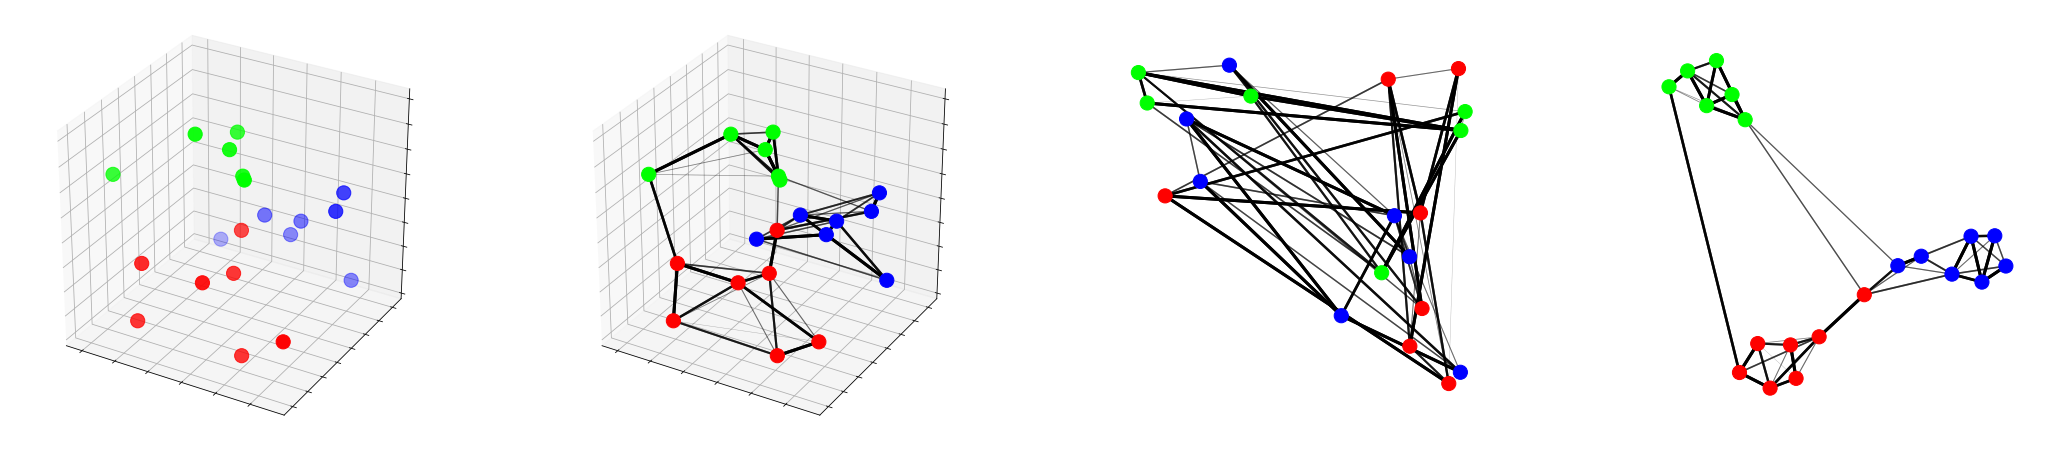

In [61]:
node_size = 200
cmap = plt.cm.brg # plt.cm.Dark2
ncols = 4
zm = 8
padding = 0.1

fig = plt.figure(figsize=(ncols*zm*1.15,zm))

# Initial data
ax1 = fig.add_subplot(1,ncols,1, projection='3d')
ax1.scatter(data[:,0], data[:,1], data[:,2], c=cluster_id, cmap = cmap, s=node_size)
ax1.set_xticklabels([]); ax1.set_yticklabels([]); ax1.set_zticklabels([]);


### Graph on 3d
ax2  = fig.add_subplot(1,ncols,2, projection='3d')
for idx, row in tqdm(edge_df.iterrows(), total=len(edge_df), leave=False):
    st = point_df.iloc[int(row.source)].data_
    ed = point_df.iloc[int(row.target)].data_
    ax2.plot([st[0], ed[0]], [st[1], ed[1]], [st[2], ed[2]], alpha = row.weight, color= 'k', lw=row.weight*3)
ax2.set_xticklabels([]); ax2.set_yticklabels([]); ax2.set_zticklabels([]);
ax2.scatter(data[:,0], data[:,1], data[:,2], c=cluster_id, cmap = cmap, s=200, alpha = 1.0)


### Graph on 2D
ax3  = fig.add_subplot(1,ncols,3)
ax3.scatter(random_embedding[:,0], random_embedding[:,1], c=cluster_id, cmap = cmap, s=200)

for idx, row in tqdm(edge_df.iterrows(), total=len(edge_df), leave=False):
    st = point_df.iloc[int(row.source)].random_embedding
    ed = point_df.iloc[int(row.target)].random_embedding
    ax3.plot([st[0], ed[0]], [st[1], ed[1]], alpha = row.weight, color= 'k', lw=row.weight*3, zorder=-1)
ax3.set_xticklabels([]); ax3.set_yticklabels([]);
ymin, ymax = ax3.get_ylim()
xmin, xmax = ax3.get_xlim()

new_ylim = np.array([ymin - (ymax - ymin)*padding, ymax + (ymax - ymin)*padding])
new_xlim = np.array([xmin - (xmax - xmin)*padding, xmax + (xmax - xmin)*padding])
ax3.set_ylim(new_ylim)
ax3.set_xlim(new_xlim)
[i.set_linewidth(10) for i in ax3.spines.values()]
ax3.margins(0.6)
ax3.axis('off')

### Graph on 2D
ax4  = fig.add_subplot(1,ncols,4)
ax4.scatter(points[:,0], points[:,1], c=cluster_id, cmap = cmap, s=200)

for idx, row in tqdm(edge_df.iterrows(), total=len(edge_df), leave=False):
    st = point_df.iloc[int(row.source)].embedding
    ed = point_df.iloc[int(row.target)].embedding
    ax4.plot([st[0], ed[0]], [st[1], ed[1]], alpha = row.weight, color= 'k', lw=row.weight*3, zorder=-1)
ax4.set_xticklabels([]); ax4.set_yticklabels([]);
ymin, ymax = ax4.get_ylim()
xmin, xmax = ax4.get_xlim()

new_ylim = np.array([ymin - (ymax - ymin)*padding, ymax + (ymax - ymin)*padding])
new_xlim = np.array([xmin - (xmax - xmin)*padding, xmax + (xmax - xmin)*padding])
ax4.set_ylim(new_ylim)
ax4.set_xlim(new_xlim)
[i.set_linewidth(10) for i in ax4.spines.values()]
ax4.margins(0.6)
ax4.axis('off')


#ensure_dir(FIGURE_DIR / 'UMAP_example')
#save_fig(FIGURE_DIR / 'UMAP_example' / 'dim_reduction', save_png=True, dpi=300, save_jpg=True, save_pdf=True)

#plt.tight_layout()
plt.show()

In [74]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [81]:
import seaborn as sns

In [89]:
pal = sns.color_palette('Set1', 3)
custommap = ListedColormap([
    list(pal[0])+[1],
    list(pal[1])+[1],
    list(pal[2])+[1],
], name='custommap')

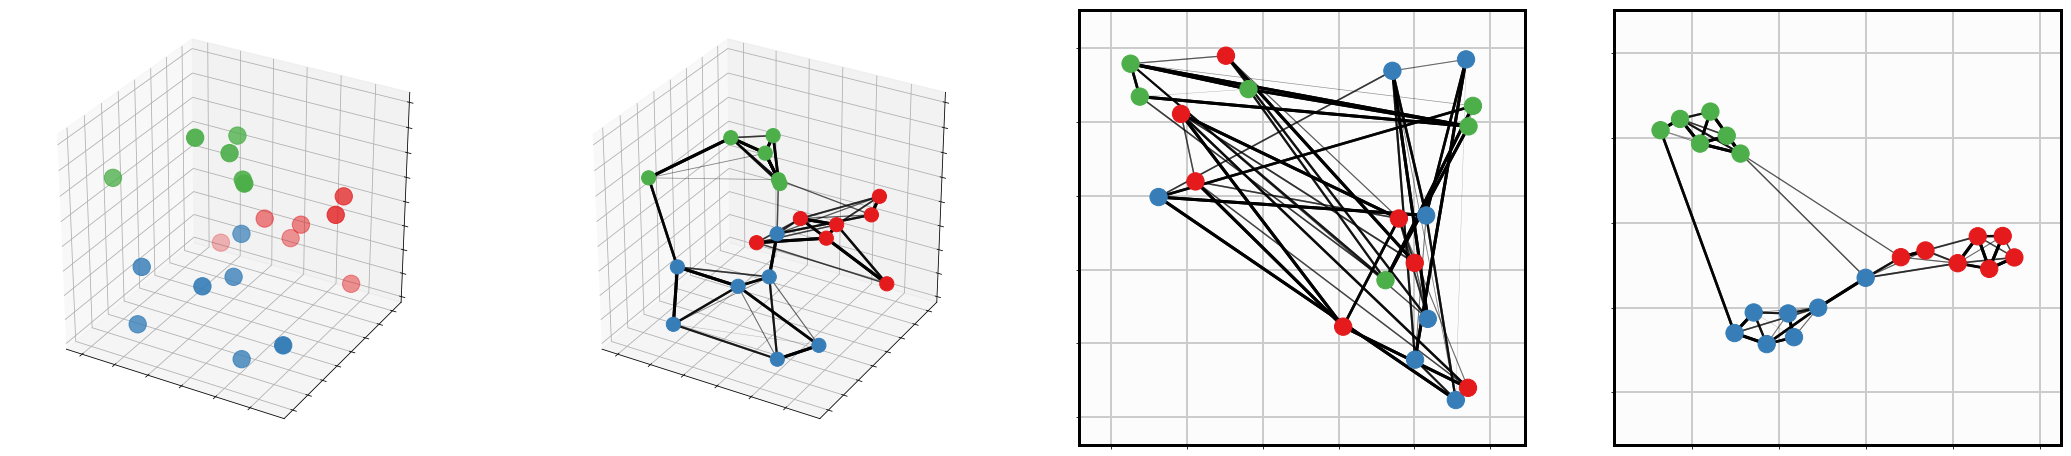

In [102]:
node_size = 300
cmap = custommap # plt.cm.tab20c# plt.cm.brg # plt.cm.Dark2
ncols = 4
zm = 8
padding = 0.05

fig = plt.figure(figsize=(ncols*zm*1.15,zm))

# Initial data
ax1 = fig.add_subplot(1,ncols,1, projection='3d')
ax1.scatter(data[:,0], data[:,1], data[:,2], c=cluster_id, cmap = cmap, s=node_size)
ax1.set_xticklabels([]); ax1.set_yticklabels([]); ax1.set_zticklabels([]);


### Graph on 3d
ax2  = fig.add_subplot(1,ncols,2, projection='3d')
for idx, row in tqdm(edge_df.iterrows(), total=len(edge_df), leave=False):
    st = point_df.iloc[int(row.source)].data_
    ed = point_df.iloc[int(row.target)].data_
    ax2.plot([st[0], ed[0]], [st[1], ed[1]], [st[2], ed[2]], alpha = row.weight, color= 'k', lw=row.weight*3)
ax2.set_xticklabels([]); ax2.set_yticklabels([]); ax2.set_zticklabels([]);
ax2.scatter(data[:,0], data[:,1], data[:,2], c=cluster_id, cmap = cmap, s=200, alpha = 1.0)


### Graph on 2D
ax3  = fig.add_subplot(1,ncols,3)
ax3.grid(b=True, which='major', color='#CCCCCC', linewidth=2, linestyle='-', zorder = -100)


for idx, row in tqdm(edge_df.iterrows(), total=len(edge_df), leave=False):
    st = point_df.iloc[int(row.source)].random_embedding
    ed = point_df.iloc[int(row.target)].random_embedding
    ax3.plot([st[0], ed[0]], [st[1], ed[1]], alpha = row.weight, color= 'k', lw=row.weight*3, zorder=1)
ax3.set_xticklabels([]); ax3.set_yticklabels([]);


ax3.scatter(random_embedding[:,0], random_embedding[:,1], c=cluster_id, cmap = cmap, s=node_size, zorder = 100)

ymin, ymax = ax3.get_ylim()
xmin, xmax = ax3.get_xlim()

new_ylim = np.array([ymin - (ymax - ymin)*padding, ymax + (ymax - ymin)*padding])
new_xlim = np.array([xmin - (xmax - xmin)*padding, xmax + (xmax - xmin)*padding])
if np.diff(new_xlim) > np.diff(new_ylim):
    new_ylim = [
        new_ylim[0] - (np.diff(new_xlim) - np.diff(new_ylim)) /2,
        new_ylim[1] + (np.diff(new_xlim) - np.diff(new_ylim)) /2
               ]
elif np.diff(new_xlim) < np.diff(new_ylim):
    new_xlim = [
        new_xlim[0] - (np.diff(new_ylim) - np.diff(new_xlim)) /2,
        new_xlim[1] + (np.diff(new_ylim) - np.diff(new_xlim)) /2
               ]
ax3.set_ylim(new_ylim)
ax3.set_xlim(new_xlim)
[i.set_linewidth(3) for i in ax3.spines.values()]
ax3.set_facecolor((0,0,0,0.01))
ax3.set_axisbelow(True)


### Graph on 2D
ax4  = fig.add_subplot(1,ncols,4)
ax4.grid(b=True, which='major', color='#CCCCCC', linewidth=2, linestyle='-', zorder = -100)

for idx, row in tqdm(edge_df.iterrows(), total=len(edge_df), leave=False):
    st = point_df.iloc[int(row.source)].embedding
    ed = point_df.iloc[int(row.target)].embedding
    ax4.plot([st[0], ed[0]], [st[1], ed[1]], alpha = row.weight, color= 'k', lw=row.weight*3, zorder=1)
ax4.set_xticklabels([]); ax4.set_yticklabels([]);

ax4.scatter(points[:,0], points[:,1], c=cluster_id, cmap = cmap, s=node_size, zorder = 100)


ymin, ymax = ax4.get_ylim()
xmin, xmax = ax4.get_xlim()

new_ylim = np.array([ymin - (ymax - ymin)*padding, ymax + (ymax - ymin)*padding])
new_xlim = np.array([xmin - (xmax - xmin)*padding, xmax + (xmax - xmin)*padding])
if np.diff(new_xlim) > np.diff(new_ylim):
    new_ylim = [
        new_ylim[0] - (np.diff(new_xlim) - np.diff(new_ylim)) /2,
        new_ylim[1] + (np.diff(new_xlim) - np.diff(new_ylim)) /2
               ]
elif np.diff(new_xlim) < np.diff(new_ylim):
    new_xlim = [
        new_xlim[0] - (np.diff(new_ylim) - np.diff(new_xlim)) /2,
        new_xlim[1] + (np.diff(new_ylim) - np.diff(new_xlim)) /2
               ]
ax4.set_ylim(new_ylim)
ax4.set_xlim(new_xlim)
[i.set_linewidth(3) for i in ax4.spines.values()]
#ax4.axis('off')
ax4.set_facecolor((0,0,0,0.01))
ax4.set_axisbelow(True)

#ax4.margins(0.5)

ensure_dir(FIGURE_DIR / 'UMAP_example')
save_fig(FIGURE_DIR / 'UMAP_example' / 'dim_reduction2', save_png=True, dpi=300, save_jpg=True, save_pdf=True)

plt.show()

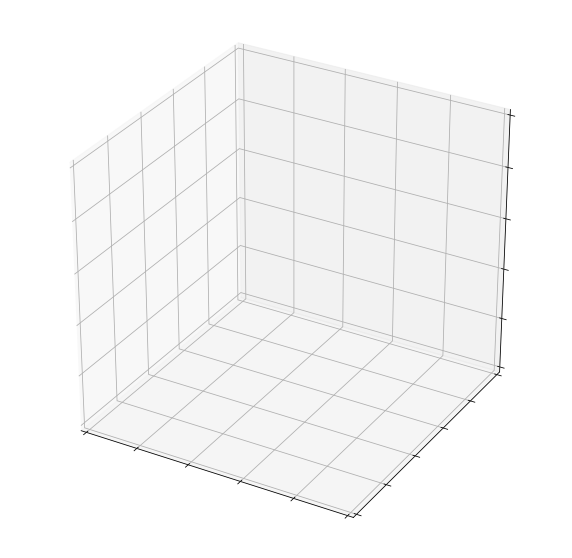

In [106]:
fig = plt.figure(figsize=(10,10))

ax  = fig.add_subplot(1,1,1, projection='3d')
ax.grid(b=True, which='major', color='#CCCCCC', linewidth=2, linestyle='-', zorder = -100)
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);


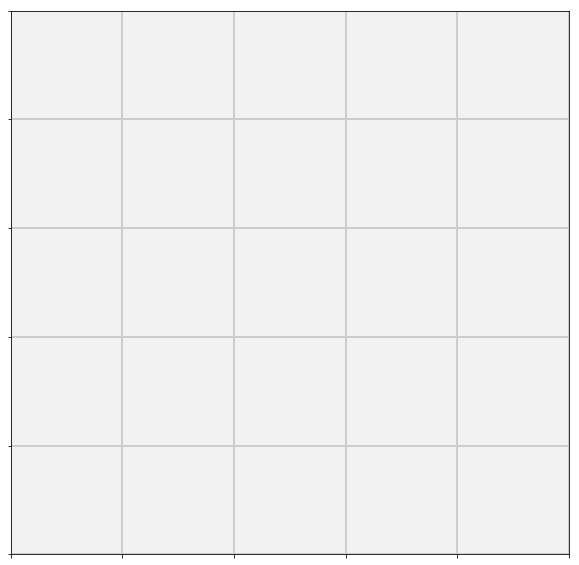

In [110]:
fig = plt.figure(figsize=(10,10))

ax  = fig.add_subplot(1,1,1,)
ax.grid(b=True, which='major', color='#CCCCCC', linewidth=2, linestyle='-', zorder = -100)
ax.set_xticklabels([]); ax.set_yticklabels([]);
ax.set_facecolor((0,0,0,0.05))
